In [301]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [302]:
haarcascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [303]:
def hog_extract(images):
    hog_features = []
    for image in images:
        image = cv2.resize(image, (64, 64))
        hog_f = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys') 
        hog_features.append(hog_f)
    return np.array (hog_features)

In [304]:
def load_detect(folder):
    images = []
    labels = []
    for l in os.listdir(folder):
        l_path = os.path.join(folder, l)
        if os.path.isdir(l_path):
            for img in os.listdir(l_path):
                img_path = os.path.join(l_path, img) 
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    faces = haarcascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        region = image[y:y+h, x:x+w]
                        images.append(region) 
                        labels.append(l)
    return images, labels

In [305]:
#---CK---
#training
X_train_faces, Y_train = load_detect("CK_dataset/train") 
X_train_features = hog_extract(X_train_faces)
#testing
X_test_faces, Y_test = load_detect("CK_dataset/test")
X_test_features = hog_extract(X_test_faces)

In [308]:
#---JAFFE---
#training
X_train_faces, Y_train = load_detect("JAFFE-[70,30]/train") 
X_train_features = hog_extract(X_train_faces)
#testing
X_test_faces, Y_test = load_detect("JAFFE-[70,30]/test")
X_test_features = hog_extract(X_test_faces)

In [309]:
svm_classifier = make_pipeline(StandardScaler(), SVC (kernel='rbf', C=7, gamma='scale'))
svm_classifier.fit(X_train_features, Y_train)
Y_pred = svm_classifier.predict(X_test_features)
#svm_classifier.fit(X_train_features, Y_train)

Test count 55
Accuracy: 80.0 %


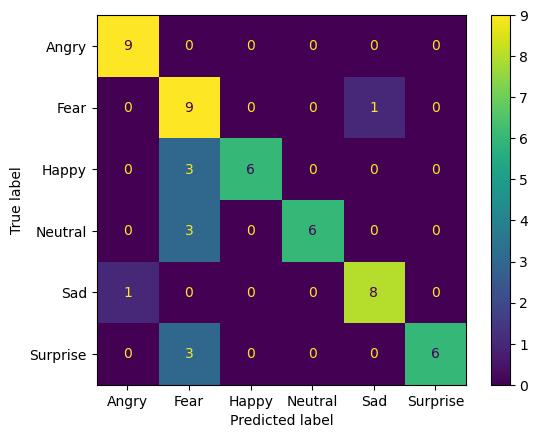

In [310]:
#Y_pred = svm_classifier.predict(X_test_features)
print("Test count", len(Y_test))
print("Accuracy:", accuracy_score(Y_test, Y_pred) * 100, "%")
conf_matrix = confusion_matrix(Y_test, Y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=svm_classifier.classes_).plot()

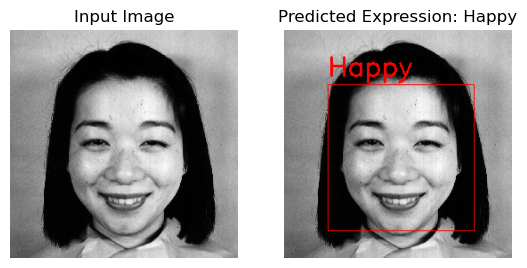

In [312]:
def hog_extract(image):
    image = cv2.resize(image, (64, 64))  
    hog_features, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return hog_features, hog_image
    
def hog_predict(path, model):
    image = cv2.imread(path, cv2. IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found.")
    faces = haarcascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        raise ValueError("No face detected.")
    (x, y, w, h) = faces[0] 
    face_region = image[y:y+h, x:x+w]
    features, hog_image = hog_extract(face_region)
    features = features.reshape(1, -1)
    predicted_expression = model.predict(features)[0]
    image_rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    #red rectangle
    image_con_box = image_rgb.copy()
    cv2.rectangle(image_con_box, (x, y), (x + w, y + h), (255, 0, 0), 1)
    cv2.putText(image_con_box, predicted_expression, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    #output
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Input Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(image_con_box)
    plt.title("Predicted Expression: " + predicted_expression)
    plt.axis('off')
    plt.show()
    
#path = "testimages_gesicht_2/48.tiff"
path = "testimages_gesicht_2/53.tiff"
hog_predict(path, svm_classifier)